# Transformer Model
---

# 1. Import required libs

In [1]:
import pandas as pd
import keras

In [2]:
import numpy as np
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.4.1


In [3]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

---

# 2. Load and visualise Data

## 2.1. Load dataset

In [4]:
ticker = "MSFT"
month = "1"
path = f"../TDL_Project_Data/{ticker}_year1_month{month}.csv"

In [5]:
from google.colab import files


uploaded = files.upload()


Saving MSFT_year1_month1.csv to MSFT_year1_month1.csv


In [6]:
import io
  
stock = pd.read_csv(io.BytesIO(uploaded['MSFT_year1_month1.csv']), parse_dates=['time'])

In [7]:
stock.head()

,time,open,high,low,close,volume,company,price_1_min_ahead,price_2_min_ahead,price_3_min_ahead,price_5_min_ahead,price_10_min_ahead,SMA,up_band_1,up_band_2,up_band_3,low_band_1,low_band_2,low_band_3,EMA,MACD,MACD_Signal,change,gain,loss,avg_gain,avg_loss,rs,RSI
0,2021-04-23 15:53:00,260.93,261.11,260.890,261.0000,105102,MSFT,260.93,261.18,261.05,261.24,261.15,261.110990,261.268152,261.425314,261.582476,260.953828,260.796666,260.639504,261.146603,-0.133621,-0.145338,0.0700,0.07,0.0000,0.029490,0.063490,0.464483,31.716498
1,2021-04-23 15:52:00,260.81,260.98,260.810,260.9100,82132,MSFT,261.00,260.93,261.18,261.05,261.15,261.087490,261.237277,261.387063,261.536850,260.937703,260.787917,260.638130,261.124069,-0.136377,-0.143545,-0.0900,0.00,0.0900,0.028015,0.064815,0.432235,30.179035
2,2021-04-23 15:51:00,261.05,261.17,260.800,260.8000,136199,MSFT,260.91,261.00,260.93,261.05,261.09,261.053495,261.185650,261.317806,261.449961,260.921340,260.789184,260.657029,261.093205,-0.145757,-0.143988,-0.1100,0.00,0.1100,0.026615,0.067075,0.396792,28.407387
3,2021-04-23 15:50:00,261.01,261.09,261.005,261.0400,50257,MSFT,260.80,260.91,261.00,261.18,261.14,261.036495,261.144011,261.251526,261.359042,260.928979,260.821464,260.713948,261.088138,-0.132300,-0.141650,0.2400,0.24,0.0000,0.037284,0.063721,0.585113,36.913021
4,2021-04-23 15:49:00,261.02,261.08,260.990,260.9946,56559,MSFT,261.04,260.80,260.91,260.93,261.16,261.023725,261.119020,261.214315,261.309610,260.928430,260.833135,260.737840,261.079230,-0.123870,-0.138094,-0.0454,0.00,0.0454,0.035420,0.062805,0.563965,36.059951


## 2.2. Close price of stock along with bollinger bands and volume

No handles with labels found to put in legend.


Text(0.5, 1.0, '')

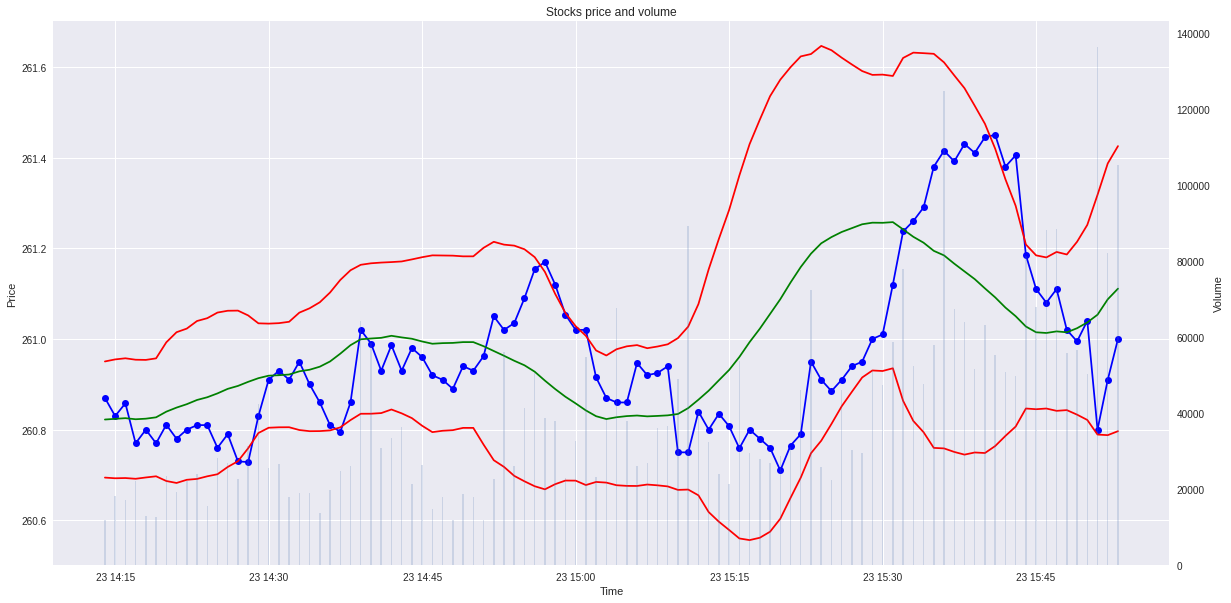

In [8]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], stock['SMA'][:100], label='Simple moving Average', color='g')

ax1.plot(stock['time'][:100], stock['up_band_2'][:100], label='', color='r')
ax1.plot(stock['time'][:100], stock['low_band_2'][:100], label='positive sentiment percentage', color='r')
    
ax2.set_xlabel("Time")
ax2.set_ylabel("Volume")
ax2.set_title(f'Stocks price and volume')
# ax1.set_ylim(0, 100)
ax2.bar(stock['time'][:100], stock['volume'][:100], width=0.0001, alpha=0.2)
ax2.grid(b=False)

ax2.legend()
plt.title("")

## 2.3. RSI, MACD, MACD Signal

Text(0.5, 1.0, 'MACD and MACD Signal')

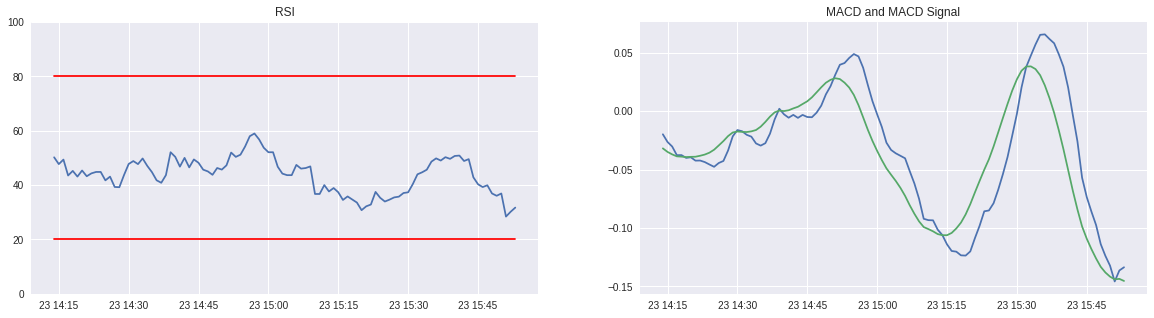

In [9]:
fig = plt.figure(figsize=(20, 5))
    
ax1 = plt.subplot2grid((1,2),(0,0))
labels = ['', '']
plt.plot(stock['time'][:100], stock['RSI'][:100])
plt.plot(stock['time'][:100], [20 for i in range(100)], color='r')
plt.plot(stock['time'][:100], [80 for i in range(100)], color='r')
plt.ylim(0, 100)
plt.title(f'RSI')
    
ax2 = plt.subplot2grid((1,2), (0, 1))
plt.plot(stock['time'][:100], stock['MACD'][:100])
plt.plot(stock['time'][:100], stock['MACD_Signal'][:100])
# plt.plot(stock['time'][:100], [20 for i in range(100)])
# plt.plot(stock['time'][:100], [80 for i in range(100)])
# plt.ylim(0, 100)
plt.title(f'MACD and MACD Signal')

---

## Hyperparameters

In [10]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256


## TimeVector

In [14]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [15]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model

In [16]:
df = stock[['time','open','high','low','close','volume']]
df.head()

,time,open,high,low,close,volume
0,2021-04-23 15:53:00,260.93,261.11,260.890,261.0000,105102
1,2021-04-23 15:52:00,260.81,260.98,260.810,260.9100,82132
2,2021-04-23 15:51:00,261.05,261.17,260.800,260.8000,136199
3,2021-04-23 15:50:00,261.01,261.09,261.005,261.0400,50257
4,2021-04-23 15:49:00,261.02,261.08,260.990,260.9946,56559


In [17]:
# Replace 0 to avoid dividing by 0 later on
df['volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('time', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()

,time,open,high,low,close,volume
8708,2021-03-25 08:49:00,235.115,235.32008,235.00839,235.15008,2274.0
8707,2021-03-25 08:54:00,235.160,235.37008,235.07439,235.20108,2203.8
8706,2021-03-25 08:59:00,235.229,235.34208,235.14700,235.26808,2031.3
8705,2021-03-25 09:01:00,235.298,235.43508,235.20200,235.33608,2178.8
8704,2021-03-25 09:04:00,235.366,235.51208,235.28100,235.41508,2325.5


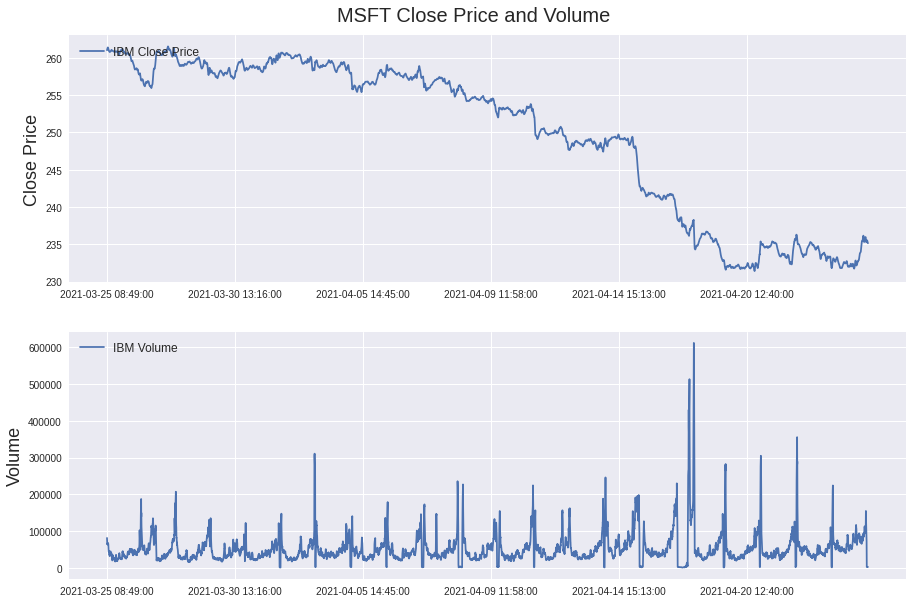

In [18]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle(f"{ticker} Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['close'], label='IBM Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['time'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['volume'], label='IBM Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['time'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [19]:
'''Calculate percentage change'''

df['open'] = df['open'].pct_change() # Create arithmetic returns column
df['high'] = df['high'].pct_change() # Create arithmetic returns column
df['low'] = df['low'].pct_change() # Create arithmetic returns column
df['close'] = df['close'].pct_change() # Create arithmetic returns column
df['volume'] = df['volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(df[['open', 'high', 'low', 'close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['open'] = (df['open'] - min_return) / (max_return - min_return)
df['high'] = (df['high'] - min_return) / (max_return - min_return)
df['low'] = (df['low'] - min_return) / (max_return - min_return)
df['close'] = (df['close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['volume'].min(axis=0)
max_volume = df['volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['volume'] = (df['volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['time'], inplace=True)
df_val.drop(columns=['time'], inplace=True)
df_test.drop(columns=['time'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (6967, 5)
Validation data shape: (871, 5)
Test data shape: (870, 5)


,open,high,low,close,volume
6966,0.367266,0.366597,0.380728,0.380727,0.019010
6965,0.378035,0.379380,0.372649,0.375343,0.018060
6964,0.373754,0.387318,0.386545,0.387457,0.019405
6963,0.391495,0.372652,0.383421,0.369959,0.017278
6962,0.367347,0.353815,0.341683,0.322848,0.015071


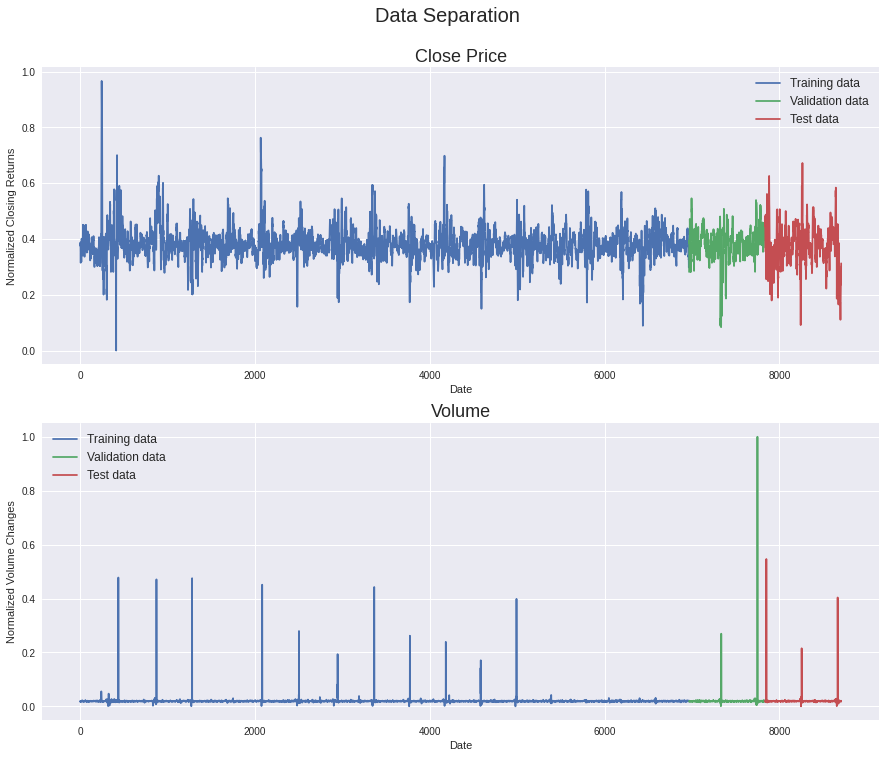

In [20]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [21]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6839, 128, 5) (6839,)
(743, 128, 5) (743,)


In [22]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 128, 2)       512         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 7)       0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 128, 7)       99114       concatenate[0][0]            

In [23]:
model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

Epoch 1/35
214/214 [==============================] - 102s 376ms/step - loss: 0.0274 - mae: 0.1125 - mape: 202.4660 - val_loss: 0.0035 - val_mae: 0.0426 - val_mape: 13.5409

Epoch 00001: val_loss improved from inf to 0.00353, saving model to Transformer+TimeEmbedding.hdf5
Epoch 2/35
214/214 [==============================] - 77s 361ms/step - loss: 0.0041 - mae: 0.0451 - mape: 1181.1639 - val_loss: 0.0034 - val_mae: 0.0401 - val_mape: 13.3124

Epoch 00002: val_loss improved from 0.00353 to 0.00337, saving model to Transformer+TimeEmbedding.hdf5
Epoch 3/35
214/214 [==============================] - 77s 360ms/step - loss: 0.0040 - mae: 0.0449 - mape: 137.0931 - val_loss: 0.0044 - val_mae: 0.0511 - val_mape: 15.1374

Epoch 00003: val_loss did not improve from 0.00337
Epoch 4/35
214/214 [==============================] - 77s 361ms/step - loss: 0.0040 - mae: 0.0449 - mape: 974.3401 - val_loss: 0.0035 - val_mae: 0.0418 - val_mape: 13.4324

Epoch 00004: val_loss did not improve from 0.00337
Ep

In [24]:
train_pred = model.predict(X_train)

In [25]:
train_pred

array([[0.3745561 ],
       [0.38276592],
       [0.39136714],
       ...,
       [0.32739988],
       [0.31806543],
       [0.3210631 ]], dtype=float32)

In [26]:
y_train

array([0.38810406, 0.39683284, 0.39951729, ..., 0.29771267, 0.3195687 ,
       0.3274594 ])

In [27]:
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0009, MAE: 0.0187, MAPE: 452.1490
Validation Data - Loss: 0.0013, MAE: 0.0214, MAPE: 7.6109
Test Data - Loss: 0.0013, MAE: 0.0254, MAPE: 8.0738


In [28]:
len(y_train), len(train_pred)

(6839, 6839)

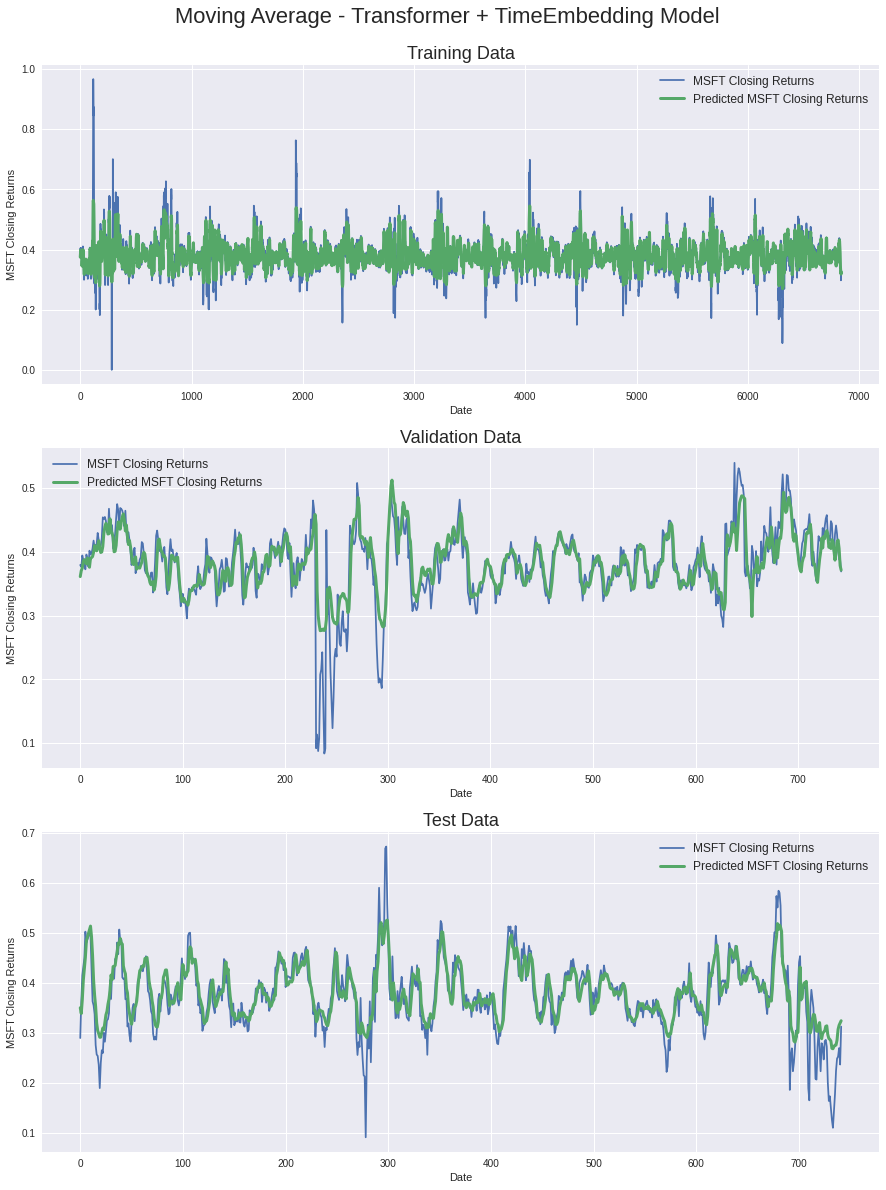

In [42]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(y_train, label='MSFT Closing Returns')
ax11.plot(train_pred, linewidth=3, label='Predicted MSFT Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('MSFT Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(y_val, label='MSFT Closing Returns')
ax21.plot( val_pred, linewidth=3, label='Predicted MSFT Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('MSFT Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(y_test[:], label='MSFT Closing Returns')
ax31.plot(test_pred[:], linewidth=3, label='Predicted MSFT Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('MSFT Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [31]:
def get_trades(actual_prices, target_prices):

    pred_labels = []
    for price in actual_prices - target_prices:
        # print(price)
        if price < 0:
            pred_labels.append(1)
        elif price == 0:
            pred_labels.append(0)
        else:
            pred_labels.append(2)

    return pred_labels

In [32]:
real_label = get_trades(y_test[:-1],y_test[1:])

In [33]:
testpred = list(map(float, test_pred))
len(testpred),len(y_test)

(742, 742)

In [34]:
pred_label = get_trades(y_test[:-1],testpred[1:])

In [35]:
from sklearn.metrics import accuracy_score

In [36]:
accuracy_score(real_label,pred_label)

0.573549257759784

In [38]:
model.save('Transformer_acc_57.h5')